# Overview


## To Recap:

The resulting ppv (position-position-velocity) cube produced by the ``optically_thin_ppv`` function provides the specific intensity, $I_{\nu}(\nu, \theta_{\rm pos}, \phi_{\rm pos})$, at the oberver's position, where $\theta_{\rm pos},\, \phi_{\rm pos}$ specify the position on the sky.[<sup>1</sup>](#fn1) This has units of ${\rm erg}\, {\rm s}^{-1}\, {\rm cm}^{-2} {\rm ster}^{-1} {\rm Hz}^{-1}$. 

It's important to understand that the synthetic cubes is not directly comparable to real world observations (even if you use the ``convert_intensity_to_Tb`` to convert the synthetic cube to brightness temperature, the form that observed ppv cubes commonly have). 

## Making Comparable Observations

If you imagined observing a simulatied object with a real-world telescope, you can think model the whole observing process as a lossy transformation $f_T$:
-  the synthetic $I_\nu(\nu, \theta_{\rm pos}, \phi_{\rm pos})$ measurements, produced by the ``optically_thin_ppv``, is effectively the telescope's inputs.
- the observing process produces an image/cube $f_T[I_\nu](\nu, \theta_{\rm pos}, \phi_{\rm pos})$. The precise details of the transformation, $f_T$, depend on the telescope's properties, and factors like exposure time.

All observational analysis is performed on reduced images (reduced images are commonly distributed by surveys(). Image reduction can be thought of as an addional transformation $f_R$ that tries to invert the transformation, $f_T$. 
- Thus, $f_R[f_T[I_\nu]] (\nu, \theta_{\rm pos}, \phi_{\rm pos})$ is comparable with real-world observations
- In practice, $f_T$ is a lossy transformation that can't be fully reversed by $f_R$. $f_T$ usually involves a convolution (that is not reversed) and the whole process introduces noise.

The bottom line is we need to come up with some approximation for a "realism-transformation" that models the combined effect of $f_R[f_T]$. ***The applied "realism-transformation" can be constructed with varying degrees of rigor (and realism). The required rigor probably depends on what exactly you are doing with the data:*** At one extreme, qualitative morphological comparisons with real-world observations may not require very rigorous transformations. In constrast, summary statistics (like the velocity structure function) *MIGHT* be sensitive to the details of the "realism-transformation"

## What we've been doing for making mock GALFA observations

All we've been doing to convert the synthetic $I_\nu(\nu, \theta_{\rm pos}, \phi_{\rm pos})$ grid to a mock observation is to convolve each velocity-channel with a Gaussian to approximate the beam size. **I'm not sure we've been doing this exactly right. (Look down below for comments in the sample code, where I highlight 2 potential issues).**

There **may be 2 important considerations**:
1. **We also haven't been modelling noise, which may be important!**
    - I suspect this may strongly influence things like VSF measurements
    - A simplistic solution that may be worth considering: select a region in the Smith cloud image where we know we are looking at empty sky. Then take I suspect we could look at the standard deviation in an  region of the Smith-Cloud cube and add white noise 

2. It's not clear that we are treating frequency channels exactly right.
   - First, does radio astronomy have an analogue to a line-spread-function? (I'm not very familiar with spectroscopy in general, but I think this is usually modelled with optical/inrared spectroscopy)?
   - Second, we currently just consider the intensity/brightness temperature at discrete frequencies. Is it more correct to think of each velocity channel as a narrow band of frequencies? In that scenario it would be more accurate to average over the intensity at all frequencies in the channel (but maybe the channel is narrow enough that we wouldn't need to worry about that anyways?)


## An aside: a somewhat faithful "realism-transformation" - CCD cameras in optical astronomy.

For the sake of example, it might be useful to briefly outline what this "realism-transformation" in the case of CCD cameras used in optical astronomy (since that's what I'm more familar with). **Note, this whole procedure is somewhat involved (and is probably more sophisticated than what we need for making mock GALFA observations).**

For simplicity, let's imagine that we're discussing an image taken with a single narrow band filter (so we just need to consider $I_\nu$ at a single frequency). We'll also ignore read noise & dark-current and assume a gain of 1. In this scenario, let's imaging that we have intensity from a source $I_{\nu, {\rm src}}(\theta_{\rm pos}, \phi_{\rm pos})$ and uniform sky emission $I_{\nu, {\rm sky}}$. Together they give a combined intensity $I_{\nu, \rm tot}(\theta_{\rm pos}, \phi_{\rm pos})=I_{\nu, \rm src}(\theta_{\rm pos}, \phi_{\rm pos}) + I_{\nu, {\rm sky}}$.[<sup>2</sup>](#fn2). We need to convolve $I_{\nu,{\rm tot}}(\theta_{\rm pos}, \phi_{\rm pos})$ by our point-spread function (commonly approximated wit a Gaussian), to get $G\ast I_\nu(\theta_{\rm pos}, \phi_{\rm pos})$.

An individual pixel on a ccd camera works by counting the number of photons that hit it. For a given pixel, you can use $G\ast I_{\nu,{\rm tot}}(\theta_{\rm pos}, \phi_{\rm pos})$ to compute the expected number of photons, $N_{\rm phot}$, collected by a single pixel during $t$ by a telescope with area $A$. Due to the nature of photon counting, the actual number of photons in a given pixel should be randomly drawn from $\mathcal{N}(\mu=N_{\rm phot},\sigma =\sqrt{N_{\rm phot}})$.

Subsequently, during image reduction observers can subtract the estimated number of sky photons photons contributed by the uniform sky emission to try get a measurement of $I_{\nu,{\rm src}}(\theta_{\rm pos}, \phi_{\rm pos})$. This measurement will still be convolved by the PSF and it will contain noise.

**AGAIN, THIS PROCEDURE IS PROBABLY MORE INVOLVED THAN ANYTHING WE'D NEED TO DO**

---------

[<sup id="fn1">1</sup>](#fn1-back) Technically, ``optically_thin_ppv`` only gives the intensity along the rays as they exit the simulation domain. But assuming that there is no foreground emission/absoprtion at these frequencies, the $I_\nu$ is constant between the locations where the rays exit the simulation domain and arrive at the observer. This discussion also implicitly assumes that there is no background emission (In the optically thin limit, background emission is easy to add).

[<sup id="fn2">2</sup>](#fn2-back) I'm a little fuzzy here on the exact details. But I think adding them together is probably fine.

In [1]:
%%time

%matplotlib inline
import numpy as np
import unyt
from astropy.convolution import Gaussian2DKernel, convolve, convolve_fft

from gasimage import convert_intensity_to_Tb, convert_Tb_to_intensity
from gasimage.utils.fits import write_cube_to_fits, read_cube_from_fits

def convolve_image(cube, std_dev_deg, degrees_per_pixel,
                   kernel_kwargs = {}, convolve_kwargs = {}):
    """
    Convolve the image/cube with a 2D normalized Gaussian kernel.
    
    Parameters
    ----------
    cube : `np.ndarray` or `unyt.unyt_array`
        This is either a 3D array representing a spectral cube. If this 
        represents a spectral cube, then we assume that the  `image.shape[-2:]` 
        specifies the spectral cube's spatial dimensions
    std_dev_deg : float
        Specifies the standard deviation of the Gaussian Kernel in degrees
    degrees_per_pixel:
        float that specifies the number of degrees per pixel
        
    NOTE: it probably
    """
    # we assume that the last 2 dimensions encode spatial dimensions
    gaussian_2D_kernel = Gaussian2DKernel(std_dev_deg/degrees_per_pixel,
                                          **kernel_kwargs)
    out = np.empty(shape = cube.shape, dtype = cube.dtype)

    cube_view = cube.view()
    if isinstance(cube, unyt.unyt_array):
        cube_view = cube.ndarray_view()        

    if len(cube.shape) != 3:
        raise ValueError('cube must be a 3D array')

    for i in range(cube_view.shape[0]):
        out[i,:,:] = convolve(
            cube_view[i,:,:],
            kernel = gaussian_2D_kernel,
            **convolve_kwargs
        )
        
    if isinstance(cube, unyt.unyt_array):
        return unyt.unyt_array(out, cube.units)
    return out




# change this variable to specify the result of radiative transfer
# made in the other notebook
_PATH = './tutorial_result_finer_pixes.fits'

orig_ppv_Tb, cube_info = read_cube_from_fits(_PATH)

ra, dec = cube_info.get_ra_dec(cube_shape = orig_ppv_Tb.shape, units = 'deg',
                               unyt_arr = False)
v_channels = cube_info.get_v_channels(orig_ppv_Tb.shape, units = 'km/s', 
                                      unyt_arr = True)

ppv = convert_Tb_to_intensity(ppv_Tb = orig_ppv_Tb, 
                              v_channels = v_channels,
                              rest_freq = cube_info.observed_freq)

# IMPORTANT OUTSTANDING QUESTION #1:
# -> Are we using a Gaussian of the right size? I have no idea where
#    where we got this number of 4 arcminutes from?

smooth_FWHM_arcmin = 4.0
smooth_FWMH_deg = smooth_FWHM_arcmin / 60.0
smooth_std_dev_deg = (
    0.5*smooth_FWMH_deg/(np.sqrt(2*np.log(2)))
)

# we are implicitly assuming that the number of degrees per pixel is constant
# along right-ascension axis and declination axis
#
# THIS BRINGS US TO AN IMPORTANT OUTSTANDING QUESTION #2:
# -> Is using the standard euclidean distance formula for computing distances between
#    2 pixels (in the context of convolution) an ok choice? I would imagine that the
#    answer is probably yes, but it's probably worth thinking about.
# -> For context, there are formulas for computing the sortest distance between points
#    at arbitrary (celestial) latitude and longitude, that can be found here:
#       https://en.wikipedia.org/wiki/Great-circle_distance
#    In reality, I THINK it probably doesn't matter too much for distances 
degrees_per_pixel = np.diff(dec)[0]


# IMPORTANT: you should look into the various kwargs for
# - Gaussian2D Kernel (https://docs.astropy.org/en/stable/api/astropy.convolution.Gaussian2DKernel.html)
# - convolve (https://docs.astropy.org/en/stable/api/astropy.convolution.convolve.html)
# - convolve_fft (https://docs.astropy.org/en/stable/api/astropy.convolution.convolve_fft.html)
#
# Specifically, you should look at handling of the boundaries!
convolved = convolve_image(cube = ppv, std_dev_deg = smooth_std_dev_deg, 
                           degrees_per_pixel = degrees_per_pixel,
                           kernel_kwargs = {},
                           convolve_kwargs = {})

mock_obs = convolved

# We should probably be adding some kind of noise to the mock_obs

mock_obs_Tb = convert_intensity_to_Tb(ppv = mock_obs, v_channels = v_channels,
                                      rest_freq = cube_info.observed_freq)

# I think it's generally a good idea to save the "mock observation" separately from
# the radiative transfer output. That way, you can remake the "mock observation"
# more quickly in the future (without redoing radiative transfer) if you decide to
# modify the procedure in the future.
write_cube_to_fits('mock_obs.fits', ppv_Tb = mock_obs_Tb,
                   cube_info = cube_info,
                   writeto_kwargs = {'overwrite' : True})

CPU times: user 17 s, sys: 1.18 s, total: 18.2 s
Wall time: 17.4 s


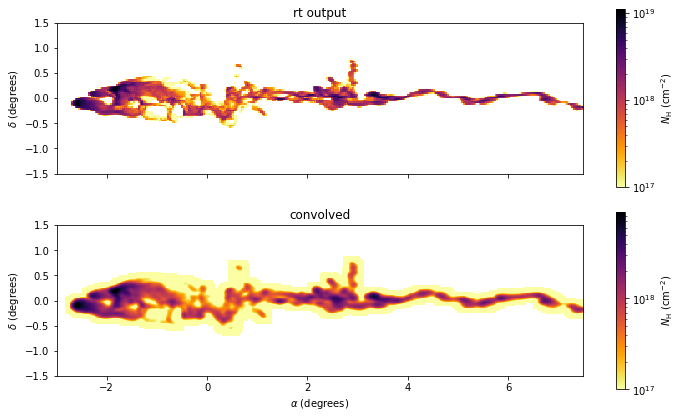

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def crude_moment0_map(ppv_Tb, v_channels):
    # this comes from Yong's script. I wasn't super careful here copying over...

    k2cm2 = 1.823e18  # from K km/s to cm-2. Can be found in the ISM book, Draine 2004
    delv = np.mean(np.diff(v_channels))
    colden = (ppv_Tb*delv).sum(0)
    return (colden.to('K*km/s').v *k2cm2) / unyt.cm**2

def plot_crude_moment0(ax, ppv_Tb, cube_info, vmin = None, vmax = None):
    
    ra, dec = cube_info.get_ra_dec(cube_shape = ppv_Tb.shape, units = 'deg',
                               unyt_arr = False)
    v_channels = cube_info.get_v_channels(ppv_Tb.shape, units = 'km/s', 
                                          unyt_arr = True)

    moment0 = crude_moment0_map(ppv_Tb, v_channels)
    im = ax.imshow(
        moment0.v, norm = LogNorm(vmin = vmin, vmax = vmax),
        extent = [ra.min(), ra.max(),
                  dec.min(), dec.max()],
        interpolation = 'none',
        cmap = 'inferno_r'
    )

    plt.colorbar(im, ax = ax,
                 label = r'$N_{\rm H}$ (${\rm cm^{-2}}$)')
    
fig,ax_arr = plt.subplots(2,1, figsize = (10,6),sharex=True,sharey=True)
plot_crude_moment0(ax_arr[0],orig_ppv_Tb, cube_info, vmin = 1e17)
ax_arr[0].set_title('rt output')
plot_crude_moment0(ax_arr[1],mock_obs_Tb, cube_info, vmin = 1e17)
ax_arr[1].set_title('convolved')
for i in range(len(ax_arr)):
    if (i+1) == len(ax_arr):
        ax_arr[i].set_xlabel(r'$\alpha$ (degrees)')
    ax_arr[i].set_ylabel(r'$\delta$ (degrees)')
fig.tight_layout()